In [ ]:
import time
start_time = time.time()

# Running Time of the Notebook" – Place this at the end.
print("{:.2f} minutes".format((time.time()-start_time)/60))

0.00 minutes


In [ ]:
!pip install scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 7.4 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=8133b507b3c0b9bc25cd14c6bc78ca6b7e250fa5515e6d2676c35cc36fddcaa8
  Stored in directory: /root/.cache/pip/wheels/4e/56/35/a748fc57279a4b84d0b332879445fed1ad8478e7257986b015
Successfully built session-info


In [ ]:
import scanpy as sc
from scipy import sparse
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.sparse as sp
from sklearn.metrics import silhouette_samples
from scipy.sparse import issparse
from joblib import Parallel, delayed
from tqdm import tqdm

In [ ]:

print(f"scanpy_version: {sc.__version__}")
print(f"pandas_version: {pd.__version__}")
print(f"numpy_version: {np.__version__}")
print(f"statsmodels_version: {sm.__version__}")
# print(f"scipy_version: {scipy.__version__}")



scanpy_version: 1.10.4
pandas_version: 2.2.2
numpy_version: 1.26.4
statsmodels_version: 0.14.4




---



# **Part 1: Batch Effect Correction Using NB-GLM (20 points)**

We correct batch effects in gene expression data by fitting a Negative Binomial Generalized Linear Model (NB-GLM) per gene, accounting for batch labels as covariates.



##### **Negative Binomial Model for Gene Expression**

The observed gene expression count $ x_{cg} $ for gene $ g $ in cell $ c $ follows a Negative Binomial (NB) distribution:

$$
x_{cg} \sim NB(\mu_{cg}, \theta_g)
$$

where:
$ x_{cg} $: Observed count of gene $ g $ in cell $ c $, $ \mu_{cg} $: Expected expression of gene $ g $ in cell $ c $, $ \theta_g $: Dispersion parameter for gene $ g $

##### **Log-Link Function in the GLM**

The expected gene expression is modeled using a log-link function in the GLM:

$$
\log(\mu_{cg}) = \beta_{0g} + \sum_{j=1}^{B} \beta_{jg} X_{cj}
$$

where: $ \beta_{0g} $: Intercept (baseline expression for gene $ g $), $ \beta_{jg} $: Batch effect coefficient for batch $ j $, $ X_{cj} $: One-hot encoded batch variable (1 if cell $ c $ belongs to batch $ j $, otherwise 0)

##### **Estimating Batch Effects**

The estimated batch effect for each cell is:

$$
\hat{B}_{cg} = \sum_{j=1}^{B} \hat{\beta}_{jg} X_{cj}
$$

where: $ \hat{B}_{cg} $:Estimated batch correction term for gene $ g $ in cell $ c $,  $ \hat{\beta}_{jg} $: Batch effect coefficient for batch $ j $, $ X_{cj} $: One-hot encoded batch variable (1 if cell $ c $ belongs to batch $ j $, otherwise 0)

##### **Batch-corrected expression**:

$$
\hat{x}_{cg} = x_{cg} - \hat{B}_{cg}
$$

where: $ \hat{x}_{cg} $: Batch-corrected gene expression for gene $ g $ in cell $ c $, $ \hat{B}_{cg} $: Estimated batch effect per cell

##### **Average Sihouette Coefficient (ASC)**
The average silhouette coefficient SC is computed as:

$$
ASC = \max_k s_{av}(k)
$$
where $s_{av}(k)$ is the mean of the sihoulette value $s(i)$ over all data in the entire dataset for a specific number of clusters $k$.

The silhouette value $s(i)$ for one data point $i$ is defined as

$$
s(i) = \frac{b(i)-a(i)}{\max\{a(i), b(i)\}}, \text {if } |C_I| > 1 \\
$$
$$ $$
$$
s(i) = 0, \text {if } |C_I| = 1.
$$

$a(i)$ is the mean distance between a point $i$ and all other points in the same cluster $C_I$, defined by:

$$
a(i) = \frac{1}{|C_I| -1 } \large\sum_{j \in C_I, i \neq j}\small d(i,j),
$$
where $d(i,j)$ is the distance between points $i$ and $j$ in the cluster $C_I$.  
$$ $$
$b(i)$ is the smallest mean distance of $i$ to all points in any other cluster, of which $i$ is not a member,

$$
b(i) = \min_{J\neq I}\frac{1}{|C_J|} \large\sum_{j \in C_J}\small d(i,j).
$$



# **[Data_Download](https://drive.google.com/drive/folders/1Bxm7oHptPGGkTNB-TovAjuifSM5LFEn9?usp=drive_link)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mv drive/MyDrive/'Copy of GSE127465_mouse_subset.h5ad' GSE127465_mouse_subset.h5ad

In [ ]:
merged_adata = sc.read_h5ad('GSE127465_mouse_subset.h5ad')
merged_adata

AnnData object with n_obs × n_vars = 4569 × 5000
    obs: 'Tumor or healthy', 'Biological replicate', 'Library', 'Barcode', 'Library prep batch', 'Total counts', 'Percent counts from mitochondrial genes', 'Most likely Immgen cell type', 'Major cell type', 'Minor subset', 'x', 'y', 'batch'
    uns: 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

This matrix is 4,569 cells by 5,000 genes.

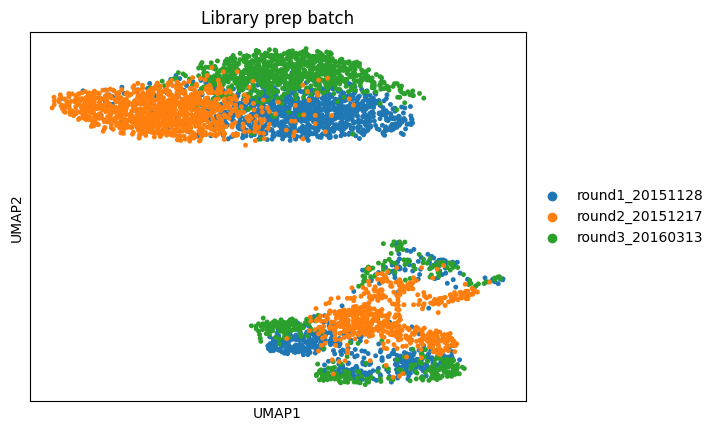

In [ ]:
# plot UMAP
sc.tl.umap(merged_adata)
sc.pl.umap(merged_adata, color = 'Library prep batch',size = 50)

In [ ]:
# your code here
# Compute silhouette scores
silhouette_scores = silhouette_samples(merged_adata.obsm['X_umap'], merged_adata.obs['Library prep batch'])

# Calculate the average silhouette coefficient (ASC)
asc = np.mean(silhouette_scores)

asc

0.0484367

In [ ]:

# Extract the expression matrix from the AnnData object
expr = merged_adata.X.toarray() if issparse(merged_adata.X) else merged_adata.X

# One-hot encode the "Library prep batch" covariate (dropping the first category)
b_labels = pd.get_dummies(merged_adata.obs["Library prep batch"], drop_first=True).astype(int)

# Prepare an array to store the batch-corrected expression values
corr_expr = np.zeros_like(expr)

# Fit NB-GLM (parallelized)
def fit_nb_glm(geneid):
    # Add 1 to avoid log(0)
    counts = expr[:, geneid] + 1

    # Create the design matrix with an intercept and batch covariates
    X_batch = sm.add_constant(b_labels.values)

    # ----- Step 1: Fit NB-GLM -----
    # We use the Negative Binomial family with a dispersion (alpha) parameter of 1.
    model = sm.GLM(counts, X_batch, family=sm.families.NegativeBinomial(alpha=1.0))
    res = model.fit()

    # ----- Step 2: Compute batch effect then remove batch effect -----
    # The estimated batch effect is computed only from the batch covariates (exclude intercept)
    # Note: X_batch has shape (n_cells, 1 + n_batches_dropped) so we slice out the columns after the first.
    batch_effect = np.dot(X_batch[:, 1:], res.params[1:])

    # Remove the estimated batch effect from the observed counts
    corrected_value = counts - batch_effect

    return geneid, corrected_value

# Process the genes in batches in parallel
batch_size = 500
num_genes = expr.shape[1]
for start in tqdm(range(0, num_genes, batch_size)):
    end = min(start + batch_size, num_genes)
    results = Parallel(n_jobs=-1)(delayed(fit_nb_glm)(geneid) for geneid in range(start, end))
    for geneid, corrected_vals in results:
        corr_expr[:, geneid] = corrected_vals

# Replace the original expression matrix with the batch-corrected expression
merged_adata.X = corr_expr


100%|██████████| 10/10 [00:41<00:00,  4.13s/it]


**c) Plot the batch corrected data using UMAP, coloring by covariate. Compute the ASC (using silhouette_samples from sklearn.metrics) after batch correction.(5 points)**

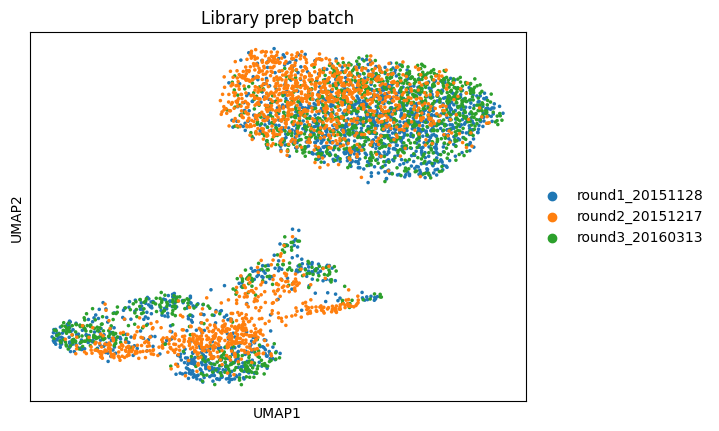

In [ ]:
# generate umap using the batch_corrected matrix
sc.pp.pca(merged_adata)
sc.pp.neighbors(merged_adata)
sc.tl.umap(merged_adata)
sc.pl.umap(merged_adata, color="Library prep batch")

In [ ]:
#your code here
silhouette_scores = silhouette_samples(merged_adata.obsm['X_umap'], merged_adata.obs['Library prep batch'])

# Calculate the average silhouette coefficient (ASC)
asc = np.mean(silhouette_scores)

asc

-0.025513595

# **Part 2: Evaluate variance stabilizing transformations**





In [ ]:
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt #You can use other plotting packages like seaborn




# **Read in data for analysis**
**The** **dataset**

This dataset is from a Drop-seq experiment whose purpose was to conduct a single-cell study of the early Drosophila (fruit fly) embryo at particular stages of development (Karaiskos et al., 2017), from both Drosophila melanogaster and Drosophila virilis species. Over 5000 embryos were sequenced to generate a predictive 3D map of gene expression during development across the embryo (using previous in situ hybridization data).

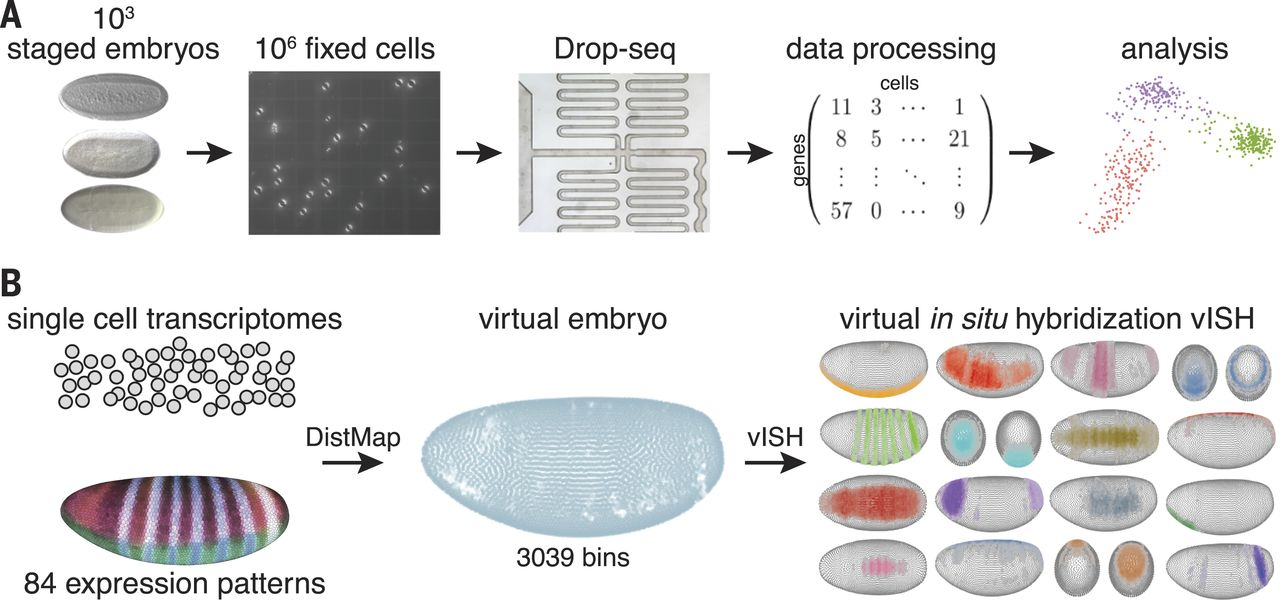

**The** **count matrix**

The gene count matrix is 3,247 cells by 23,712 genes. These counts have not been processed/normalized, so they directly represent the UMI counts from each cell.

In [ ]:
count_mat

array([[  6, 665, 120, ...,  11,   3,   0],
       [  4, 370,  49, ...,   9,   1,   0],
       [  0,   4,   0, ...,   0,   0,   0],
       ...,
       [  0,   1,   0, ...,   0,   0,   0],
       [  0,   3,   0, ...,   0,   0,   0],
       [  0,   1,   0, ...,   0,   0,   0]])

For our purposes, we will use the $\mu$, $\phi$
 parametrization of the negative binomial (NB) for this problem. Here
 $\phi$  is the dispersion and
  $\mu$ is the mean.
  In this configuration, $var(X) = \mu + \phi \mu^2$
 (unlike the Poisson where $var(X) = \mu$
). $x_i$
 represents expression of gene  $i$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit

**a) Run PCA on the data matrix (with genes as features), extract the top two principal components and transform the data matrix, then plot the cells in their 2D, transformed coordinates.**



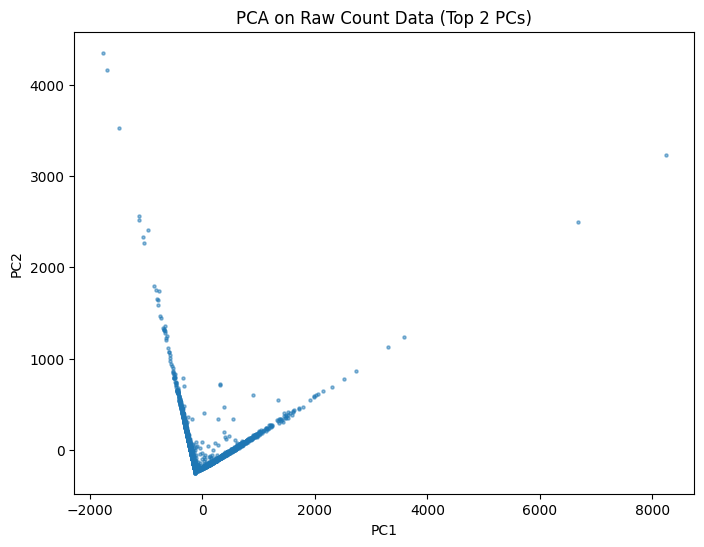

In [ ]:
# ---------------------------
# (a) PCA on raw data (genes as features)
# ---------------------------
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(count_mat)  # count_map: cells x genes

plt.figure(figsize=(8, 6))
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], s=5, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA on Raw Count Data (Top 2 PCs)')
plt.show()

**b)** **Plot the variance ($\phi$) versus the mean ($\mu$) expression for all genes in a single plot, and comment on any trends you notice (how variance relates to the mean)**

You will need to calculate a $\mu$ and $\phi$ for each gene.

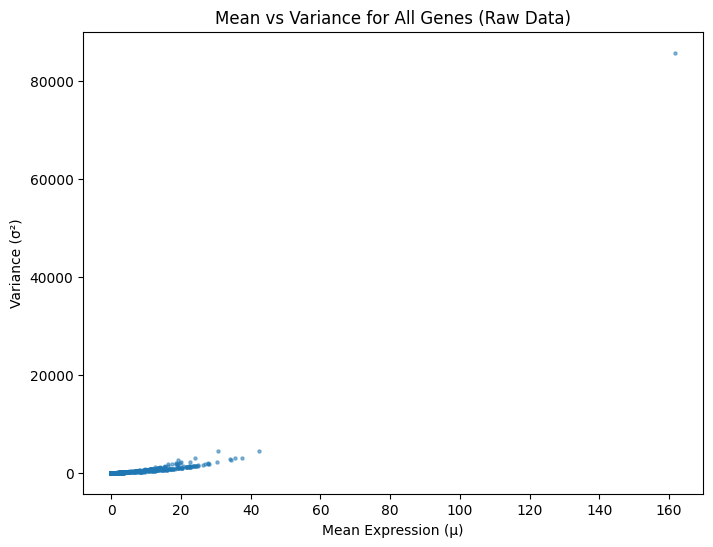

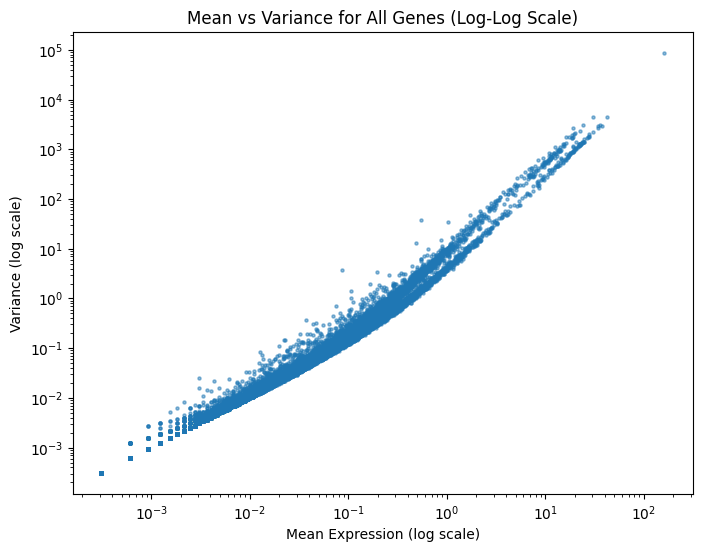

In [ ]:
# ---------------------------
# (b) Compute and plot the empirical mean and variance (per gene)
# ---------------------------
# For each gene (i.e. each column) compute the mean and variance across cells.


gene_means = np.mean(count_mat, axis=0)
gene_vars  = np.var(count_mat, axis=0, ddof=1)  # using sample variance

plt.figure(figsize=(8, 6))
plt.scatter(gene_means, gene_vars, s=5, alpha=0.5)
plt.xlabel('Mean Expression (μ)')
plt.ylabel('Variance (σ²)')
plt.title('Mean vs Variance for All Genes (Raw Data)')
plt.show()

# Plot with log-log scale
plt.figure(figsize=(8, 6))
plt.scatter(gene_means, gene_vars, s=5, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean Expression (log scale)')
plt.ylabel('Variance (log scale)')
plt.title('Mean vs Variance for All Genes (Log-Log Scale)')
plt.show()

### Comment on how variance relates to mean in plots :
Using the log scale to analyze the relationship between mean expression and variance it appears that expression increases nearly linearly with the variance

**c) Fit a polynomial to $\sigma^2$ vs $\mu$ (the plot from b) to approximate a single $\phi$ value (across all genes). (5 points)**

$\sigma^2$ is $var(X) = \mu + \phi \mu^2$.

Given that you can find the fit for $\phi$ as the coefficent for the squared term. You can use the package **curve_fit** from **scipy.optimize**, to define this degree 2 polynomial where $x=\mu$ and $y=var(X)$. Using the bounds options you can constrain the constant to be 0, the first coefficient to be 1, and learn the second coefficient ($\phi$).

See a constrained fit example [here](https://stackoverflow.com/questions/48469889/how-to-fit-a-polynomial-with-some-of-the-coefficients-constrained).




Estimated global dispersion (phi): 3.2536418395852307


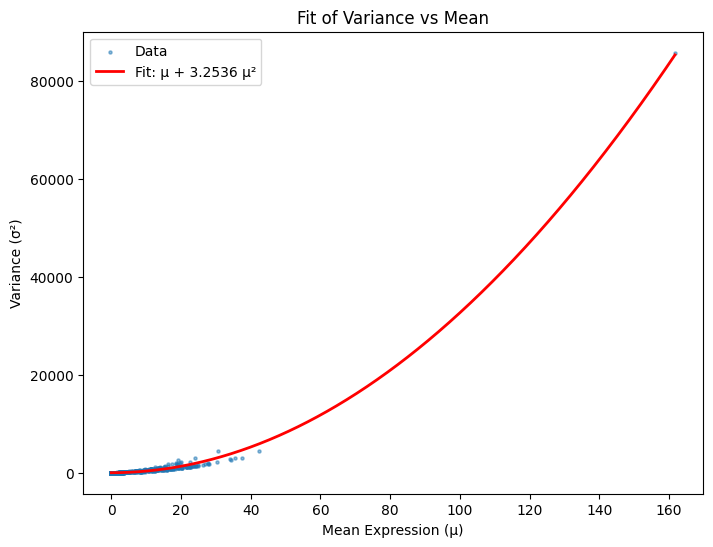

In [ ]:
# ---------------------------
# (c) Fit a quadratic model to estimate a global dispersion (φ)
# The model is: f(μ; φ) = μ + φ μ².
# ---------------------------
def nb_poly(mu, phi):
    return mu + phi * mu**2

# Use curve_fit to fit the model to (gene_means, gene_vars)
# We constrain phi to be nonnegative.
popt, pcov = curve_fit(nb_poly, gene_means, gene_vars, bounds=(0, np.inf))
phi_global = popt[0]
print("Estimated global dispersion (phi):", phi_global)

# Overlay the fitted curve on the scatter plot:
mu_fit = np.linspace(gene_means.min(), gene_means.max(), 1000)
var_fit = nb_poly(mu_fit, phi_global)

plt.figure(figsize=(8, 6))
plt.scatter(gene_means, gene_vars, s=5, alpha=0.5, label='Data')
plt.plot(mu_fit, var_fit, color='red', lw=2, label=f'Fit: μ + {phi_global:.4f} μ²')
plt.xlabel('Mean Expression (μ)')
plt.ylabel('Variance (σ²)')
plt.title('Fit of Variance vs Mean')
plt.legend()
plt.show()

**d) Run the log1p, Pearson residual, and variance stabilization transforms on the full dataset. (10 points)**

Below you will test out the effect of common variance-stabilization procedures.

In 1948, Frank Anscombe developed several transformations for the Poisson and NB distributions including

$ y \propto \frac{\sinh^{-1}(\sqrt{\phi x_i})}{\sqrt{\phi}}$

and
$ y \propto \log(x_i + \frac{1}{2\phi})$

(similar to the log1p we've seen before) which can approximate the $\sinh^{-1}$ solution.


Another common method is to use Pearson residuals, shown below:


$y \propto \frac{x_i - \mu_i}{\mu_i + \phi \mu_i^2}$, where $x_i$ represents gene expression of gene $i$.


After running each transformation (on the full data), print only the transformed values for the first gene, for the first 10 cells, under each transform (1-3).




In [ ]:
# ---------------------------
# (d) Run three transformations on the full dataset.
#     For each transform, print the transformed values for the first gene (first 10 cells).
# ---------------------------
# Precompute per-gene means (for use in the Pearson residual transform)
mu_genes = gene_means  # same as computed above

# 1. log1p transform
log1p_transform = np.log1p(count_mat)

# 2.1. Pearson residual transform :
#    For each cell i and gene j:
#         y_ij = (x_ij - μ_j) / μ_j + φ_global * μ_j²
pearson_resid = (count_mat - mu_genes) / mu_genes + phi_global * mu_genes**2

# 2.2. Pearson residual transform w/ sqrt:
#    For each cell i and gene j:
#         y_ij = (x_ij - μ_j) / sqrt(μ_j + φ_global * μ_j²)
pearson_resid2 = (count_mat - mu_genes) / np.sqrt(mu_genes + phi_global * mu_genes**2)

# 3. Variance stabilization transform (Anscombe’s asinh version):
#    y = asinh( sqrt(φ_global * x) ) / sqrt(φ_global)
var_stab = np.arcsinh(np.sqrt(phi_global * count_mat)) / np.sqrt(phi_global)

# Print the first 10 transformed values for the first gene from each method:
print("Log1p transform (first gene, first 10 cells):")
print(f"{log1p_transform[:10, 0]}\n")

print("Pearson residuals (first gene, first 10 cells):")
print(f"{pearson_resid[:10, 0]}\n")

print("Pearson residuals w/ sqrt in denom. (first gene, first 10 cells):")
print(f"{pearson_resid2[:10, 0]}\n")

print("Variance stabilization (asinh transform) (first gene, first 10 cells):")
print(f"{var_stab[:10, 0]}")


Log1p transform (first gene, first 10 cells):
[1.94591015 1.60943791 0.         0.         0.         0.
 0.         0.         0.         0.        ]

Pearson residuals (first gene, first 10 cells):
[112.93884853  74.96224034  -0.99097604  -0.99097604  -0.99097604
  -0.99097604  -0.99097604  -0.99097604  -0.99097604  -0.99097604]

Pearson residuals w/ sqrt in denom. (first gene, first 10 cells):
[23.9454092  15.89292682 -0.21203796 -0.21203796 -0.21203796 -0.21203796
 -0.21203796 -0.21203796 -0.21203796 -0.21203796]

Variance stabilization (asinh transform) (first gene, first 10 cells):
[1.2149346  1.10592982 0.         0.         0.         0.
 0.         0.         0.         0.        ]


**e) For each of the three transformation methods, make a single plot of the variance ($\sigma^2$) versus the mean ($\mu$) for all genes, and comment on the trends you notice (particularly compared to b). (5 points)**

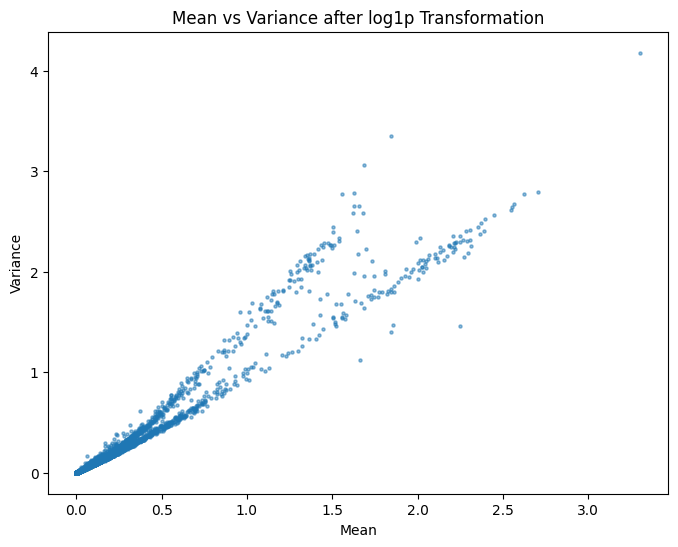

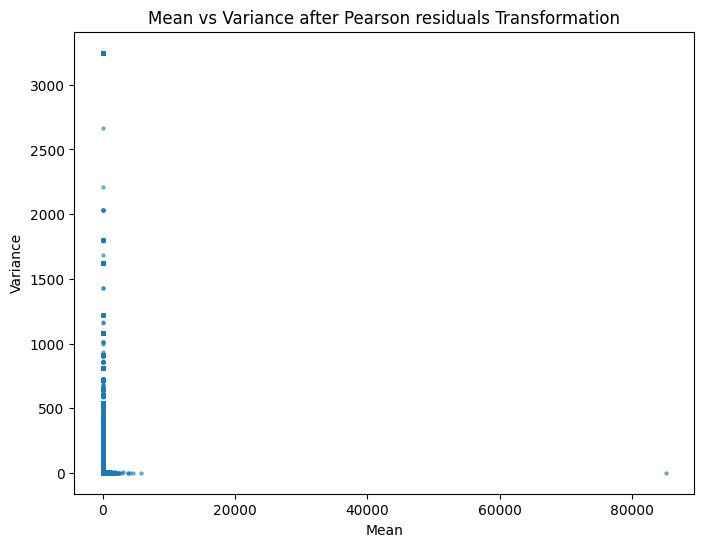

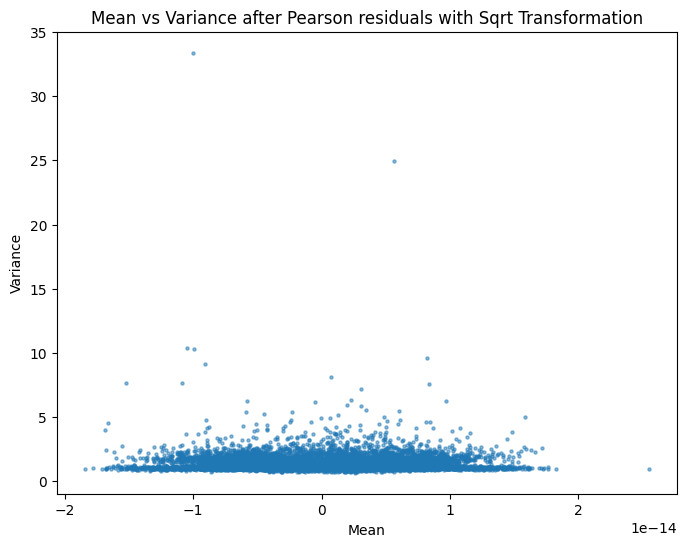

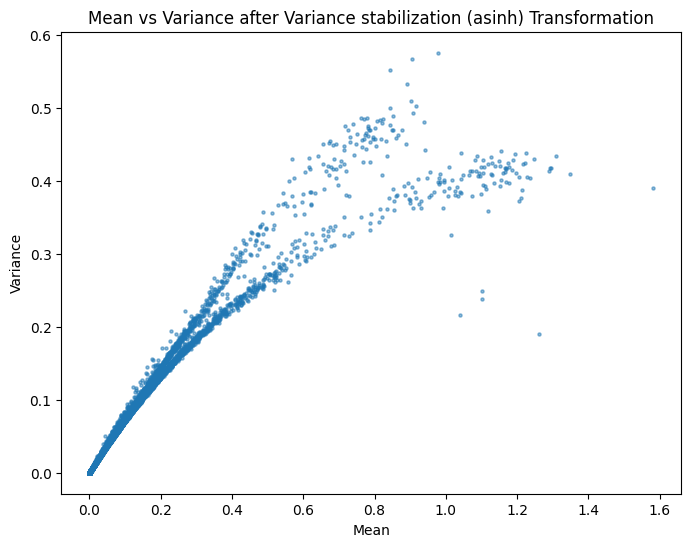

In [ ]:
# ---------------------------
# (e) For each transformation, plot the variance vs mean (per gene).
# ---------------------------
transformations = {
    'log1p': log1p_transform,
    'Pearson residuals': pearson_resid,
    'Pearson residuals with Sqrt': pearson_resid2,
    'Variance stabilization (asinh)': var_stab
}

for name, X_trans in transformations.items():
    gene_means_trans = np.mean(X_trans, axis=0)
    gene_vars_trans = np.var(X_trans, axis=0, ddof=1)

    plt.figure(figsize=(8, 6))
    plt.scatter(gene_means_trans, gene_vars_trans, s=5, alpha=0.5)
    plt.xlabel('Mean')
    plt.ylabel('Variance')
    plt.title(f'Mean vs Variance after {name} Transformation')
    plt.show()


### Comment on the trends you notice (particularly compared to b).

log1p : Starting to see a bit more seperartion of the variance with genes that have lower means

Pearson Residual : Seemingly too much seperation between the mean and variance, except this is flipped from (b) where the mean is changing much more relative to the variance in the raw data plot

Pearson Residual w sqrt : Seemingly good seperation where we have scattered points of lots of variance for genes with mean expression across the whole dataset

Asinh : very similar to the log1p

**f) For each transformation, run PCA on the variance-stabilized data matrices (with genes as features), extract the top two principal components and transform the matrix, then plot the cells in their 2D, transformed coordinates. There should be one plot for each transformation method. Comment on how these plots compare to that of a. (5 points)**

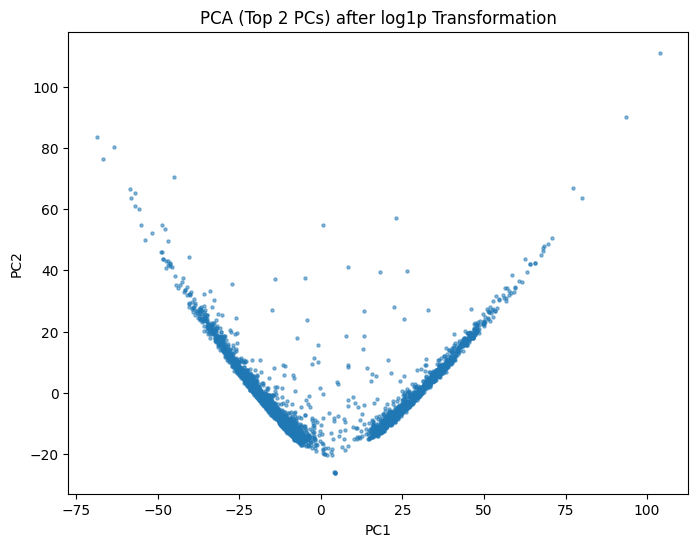

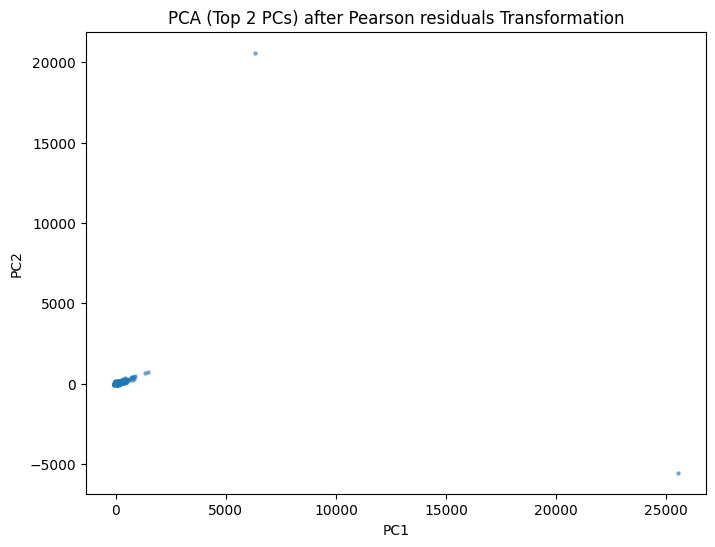

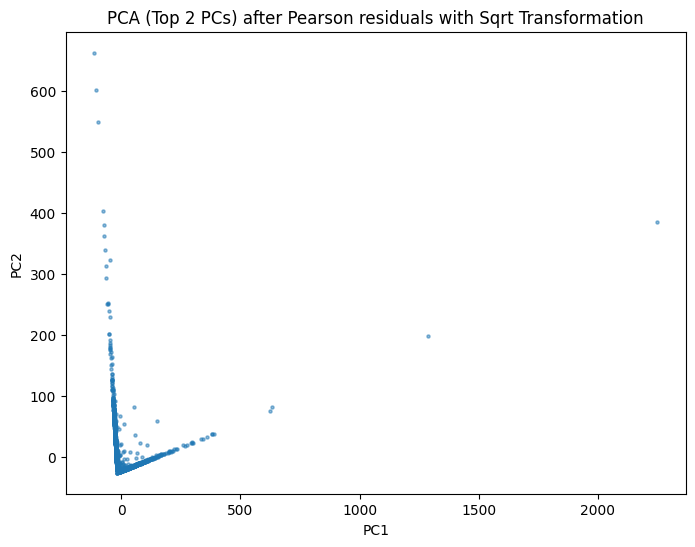

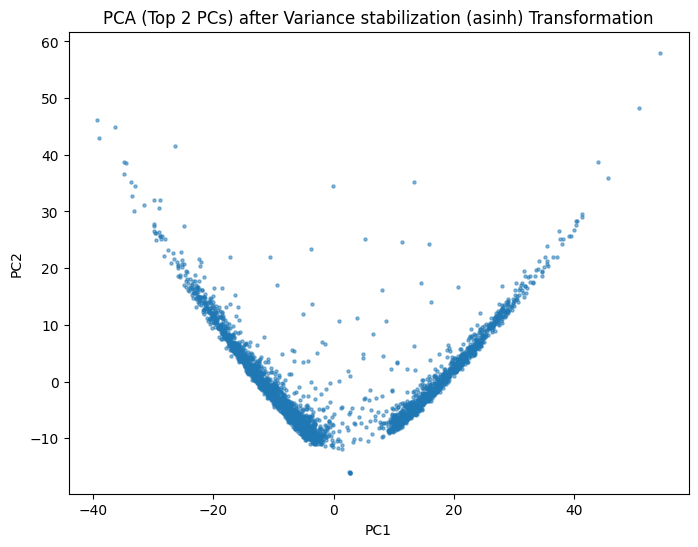

In [ ]:
# ---------------------------
# (f) Run PCA on each transformed dataset (genes as features) and plot the top two PCs.
# ---------------------------
for name, X_trans in transformations.items():
    pca = PCA(n_components=2)
    pca_trans = pca.fit_transform(X_trans)

    plt.figure(figsize=(8, 6))
    plt.scatter(pca_trans[:, 0], pca_trans[:, 1], s=5, alpha=0.5)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'PCA (Top 2 PCs) after {name} Transformation')
    plt.show()


### Comment on the trends you notice (particularly compared to a).

log1p : Very similar seperation comapred to (a)

Pearson Residual : datapoints have become more concentrated, pretty much to a single grouping

Pearson Residual w sqrt : Very similar seperation comapred to (a) and log1p

Asinh : very similar to the log1p, (a), and the pearson residual with a sqrt in the denom.

## **Part 3: Differential analysis and multiple hypothesis testing (25 points)**

In [ ]:
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt

**The dataset**

Much of mammalian embryo development occurs after the embryo implants in the uterus, however this makes the embryo relatively inaccessible and thus hard to study. In [Aguilera-Castrejon et al., 2021](https://www.nature.com/articles/s41586-021-03416-3#Sec7), a cell culture platform was established to culture post-implantation embryos ex utero (outside the uterus) from pre-gastrulation until himdlimb formation (organogenesis).  Single-cell sequencing was done for both in utero and ex utero cultured mouse embryos, to compare development of the externally cultured cells.

<center><img src="https://drive.google.com/uc?export=view&id=1b6BM_W5Nk2r31RdGE7-bKDuObQq279qh" alt="EMFigure" width="800" height="350"><center>


This matrix is 6,205 cells by 2,000 genes. We are only working with the ex-utero cultured mouse embryo cells here.

1.   For each cell, gene counts were normalized to have the same number of total counts (usually 1e5 or 1e6), with cell-gene counts thus scaled accordingly.

2.   Counts were then log-normalized, using the log(1+x), where x is each cell's gene count. The 1 accounts for 0 count genes.

3. The top ~2000 genes were selected for those that displayed large variance in expression amongst the cells ('highly variable genes').



# [**Data_download**](https://drive.google.com/drive/folders/1KqbQJW88Ofn5avn-CWvrckRKUj4_6Zzu?usp=drive_link)

In [ ]:
#Get gene count matrix
count_mat = sio.mmread('exutero.mtx')
count_mat.shape

(6205, 2000)

In [ ]:
#Get metadata dataframe for the 6,205 cells (rows of the matrix)
meta = pd.read_csv('cell_metadata.csv',index_col = 0)
meta.head()

,cell_type
AAACCCAAGTACAACA-3,Mixed Mesoderm
AAACCCAGTACACTCA-3,Blood
AAACCCATCGAAGCAG-3,Neural Tube
AAACGAAAGGAAACGA-3,Mixed Mesoderm
AAACGAACACATGGTT-3,Pharyngeal Mesoderm


In [ ]:
#Get metadata dataframe for the 2,000 genes (columns of the matrix)
meta_gene = pd.read_csv('gene_metadata.csv',index_col = 0)
meta_gene.head()


,gene_name
0,Sox17
1,Lypla1
2,Sgk3
3,Xkr9
4,Bag2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import io as sio
from scipy.stats import t as t_dist

In [ ]:
# Create a DataFrame for the counts with cell IDs as index and gene names as columns.
df_counts = pd.DataFrame(count_mat, index=meta.index, columns=meta_gene['gene_name'])


**a)Calculate the $t$ statistic (for two-samples with different sizes) for each gene, between cell types 'Cardiac' and 'Neural Tube'. Subset the count matrix for *only genes that have nonzero variances* in the 'Cardiac' or 'Neural Tube' cell types. (This will avoid nan outputs).  Report how many genes remain after subsetting and the $t$ values for the genes Sox17, Lypla1, Sgk3, Bag2. (10 points)**

'Zero variance genes' are the union of genes with 0 variance in either cell type.

We will be working only with the subsetted genes for the rest of Part 3. Recall that counts are variance stabilized already.

Given the cell types 'Cardiac(=1)  and 'Neural Tube(=2)' , we will denote all expression values of gene $g$ in Cardiac as $X^g_1$, and likewise $X^g_2$ for Neural Tube.

We will calculate a two-sample $t^g$ statistic between cell types 1 (=Cardiac)  and 2(=Neural Tube) for gene $g$. Here we pooled variances.


\begin{align}
{\displaystyle t^g={\frac {{\bar {X}}^g_{1}-{\bar {X}}^g_{2}}{s^g_{p}\cdot {\sqrt {{\frac {1}{n_{1}}}+{\frac {1}{n_{2}}}}}}}}
\end{align} where
\begin{align}
{\displaystyle s^g_{p}={\sqrt {\frac {\left(n_{1}-1\right)s_{X^g_{1}}^{2}+\left(n_{2}-1\right)s_{X^g_{2}}^{2}}{n_{1}+n_{2}-2}}}}
\end{align}


and is comprised of the standard deviations $s$ of $X^g_1$ and $X^g_2$, and the sizes of cell types 1 and 2 ($n_1 , n_2$). $\bar{X}^g_1$ denotes the mean expression for gene $g$ in cell type 1.




In [ ]:
# ============================
# (a) Two-Sample t–test (Cardiac vs Neural Tube)
# ============================
# Select cells for the two cell types of interest
group1_label = "Cardiac"
group2_label = "Neural Tube"
df_cardiac = df_counts[ meta['cell_type'] == group1_label ]
df_neural  = df_counts[ meta['cell_type'] == group2_label ]

# Get sample sizes
n1 = df_cardiac.shape[0]
n2 = df_neural.shape[0]
df_deg = n1 + n2 - 2  # degrees of freedom for pooled variance

# Compute gene–wise means and sample variances for each group
mean_cardiac = df_cardiac.mean(axis=0)
mean_neural  = df_neural.mean(axis=0)
var_cardiac  = df_cardiac.var(axis=0, ddof=1)
var_neural   = df_neural.var(axis=0, ddof=1)

# Identify genes with nonzero variance in both groups (avoid division by zero)
nonzero_genes = (var_cardiac > 0) & (var_neural > 0)
df_counts_filtered = df_counts.loc[:, nonzero_genes]
filtered_gene_names = df_counts_filtered.columns
print("Number of genes remaining after filtering (nonzero variance in both groups):",
      len(filtered_gene_names))

# Initialize dictionaries to store t–statistics and p–values for each gene
t_stats = {}
p_values = {}

# Loop over the filtered genes to compute the pooled t–statistic
for gene in filtered_gene_names:
    # Get expression vectors for the gene in each group
    X1 = df_cardiac[gene]
    X2 = df_neural[gene]
    # Compute group means
    m1 = X1.mean()
    m2 = X2.mean()
    # Compute sample variances
    s1_sq = X1.var(ddof=1)
    s2_sq = X2.var(ddof=1)
    # Pooled standard deviation
    sp = np.sqrt(((n1 - 1)*s1_sq + (n2 - 1)*s2_sq) / (n1 + n2 - 2))
    # Compute t–statistic
    t_val = (m1 - m2) / (sp * np.sqrt(1/n1 + 1/n2))
    t_stats[gene] = t_val

    # (b) Compute two-tailed p–value using the t–distribution CDF:
    # p = 2*(1 - CDF(|t|))
    p_val = 2 * (1 - t_dist.cdf(np.abs(t_val), df_deg))
    p_values[gene] = p_val

# Report the t–statistics for selected genes:
for gene in ['Sox17', 'Lypla1', 'Sgk3', 'Bag2']:
    if gene in t_stats:
        print(f"Gene: {gene}, t–statistic = {t_stats[gene]:.4f}")
    else:
        print(f"Gene: {gene} was filtered out (zero variance in one group).")


Number of genes remaining after filtering (nonzero variance in both groups): 994
Gene: Sox17, t–statistic = 1.3289
Gene: Lypla1, t–statistic = -0.7327
Gene: Sgk3, t–statistic = 2.0838
Gene: Bag2, t–statistic = -2.5997


**b) Given the $t$ values in a), find corresponding p value for pairs of  observations based on the Student's $t$ distribution. Report the $p$-values for the genes Sox17, Lypla1, Sgk3, Bag2 using the 2*(1-CDF) to compute the p-values (5 points).**

In [ ]:
# ============================
# (b) Report p–values for selected genes:
# ============================
for gene in ['Sox17', 'Lypla1', 'Sgk3', 'Bag2']:
    if gene in p_values:
        print(f"Gene: {gene}, p–value = {p_values[gene]:.4e}")
    else:
        print(f"Gene: {gene} was filtered out (no p–value computed).")

Gene: Sox17, p–value = 1.8446e-01
Gene: Lypla1, p–value = 4.6405e-01
Gene: Sgk3, p–value = 3.7660e-02
Gene: Bag2, p–value = 9.5913e-03


**To obtain *p*-values:**

You are calculating the likelihood (or how unlikely) your $t$ value is given the $t$-distribution (i.e. assuming the groups come from the same population). For this you can use the cdf feature from the scipy stats t distribution - stats.t.cdf (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html).



Remember that the CDF calculates the probability of seeing a value less than or equal to your $t$ (or abs($t$)). Thus you will need 1 minus the CDF value to find the likelihood of being more extreme. Likewise, since we are interested in whether the two means are different (meaning smaller *or* greater than the other), we will need a two-tailed test i.e. how likely it is to have a more extreme $t$ in both directions  or **2*(1-CDF)**.






For the degrees of freedom of the $t$-statistic note that since $n_i − 1$ is the number of degrees of freedom for each group, the degrees of freedom (df) for the total sample is $n_1 + n_2 − 2$.

**c) Use the Bonferroni correction method to correct the $p$-values for multiple testing. Report the corrected $\alpha$ cutoff and how many genes' $p$-values were below the cutoff *(1) before* and *(2) after* the Bonferroni correction (5 points)**

Since you have calculated $t$-tests for **every gene $g$**, you will need to correct your $p$-values to adjust for the likelihood of a positive/significant result just by virtue of the number of tests you've done. We can either adjust the $p$-values themselves, or adjust our significance cutoff.

Here we will use a significance/$p$-value cutoff of $\alpha=$0.05 (5%), where $p \le \alpha$ when $\bar{X}^g_1 = \bar{X}^g_2$ (the null $H_0$) is rejected.

The Bonferroni correction adjusts this to $\alpha/n$ where $n$ is the number of comparisons/tests made.

In [ ]:
# ============================
# (c) Multiple Testing Correction with Bonferroni
# ============================
# Uncorrected significance level:
alpha = 0.05
# Number of tests equals the number of filtered genes
num_tests = len(filtered_gene_names)
# Bonferroni corrected significance cutoff:
alpha_bonf = alpha / num_tests
print("Bonferroni corrected alpha cutoff:", alpha_bonf)

# Count how many genes have p–value < 0.05 (uncorrected)
num_sig_uncorrected = sum(1 for p in p_values.values() if p < alpha)
# Count how many genes have p–value < Bonferroni cutoff
num_sig_bonf = sum(1 for p in p_values.values() if p < alpha_bonf)
print("Number of genes with p–value < 0.05 (uncorrected):", num_sig_uncorrected)
print("Number of genes with p–value < Bonferroni cutoff:", num_sig_bonf)

Bonferroni corrected alpha cutoff: 5.030181086519115e-05
Number of genes with p–value < 0.05 (uncorrected): 260
Number of genes with p–value < Bonferroni cutoff: 112


**d) Make a volcano plot for all genes (one plot total). A volcano plot has the $p$-values on the y axis and log2(FC) (FC is fold change) on the x axis. (5 points)**

Fold change will be the **ratio of the average gene expression in one cell type to the other**. In this case do 'Cardiac'/'Neural Tube' expression.

You can also plot -log10($p$-value) for the y-axis instead of the raw $p$-values (which may be very small). After this transformation, larger $p$-values are more significant.

<ipython-input-38-b8a0dd8baa72>:12: RuntimeWarning: divide by zero encountered in log10
  y_vals = -np.log10([p_values[gene] for gene in filtered_gene_names])


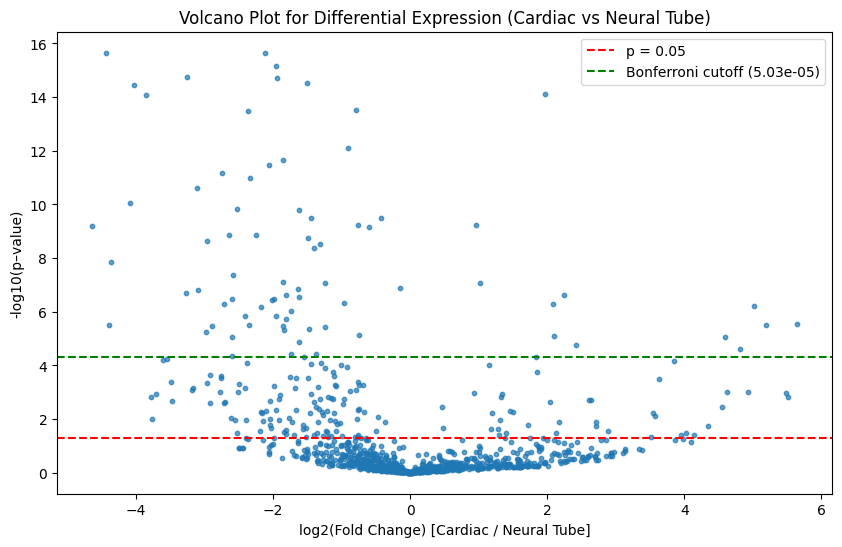

In [ ]:
# ============================
# (d) Volcano Plot
# ============================
# For each filtered gene, compute the fold change (FC) as the ratio:
# FC = (mean expression in Cardiac) / (mean expression in Neural Tube)
# Then compute log2(FC)
fold_changes = (mean_cardiac[filtered_gene_names] / mean_neural[filtered_gene_names])
log2_fc = np.log2(fold_changes)

# Prepare x (log2 fold change) and y (-log10(p–value)) for the volcano plot.
x_vals = log2_fc.values
y_vals = -np.log10([p_values[gene] for gene in filtered_gene_names])

plt.figure(figsize=(10, 6))
plt.scatter(x_vals, y_vals, s=10, alpha=0.7)
plt.xlabel('log2(Fold Change) [Cardiac / Neural Tube]')
plt.ylabel('-log10(p–value)')
plt.title('Volcano Plot for Differential Expression (Cardiac vs Neural Tube)')
# add horizontal lines for the significance thresholds
plt.axhline(-np.log10(alpha), color='red', linestyle='--', label='p = 0.05')
plt.axhline(-np.log10(alpha_bonf), color='green', linestyle='--',
            label=f'Bonferroni cutoff ({alpha_bonf:.2e})')
plt.legend()
plt.show()

In [ ]:
# Running Time of the Notebook" – Place this at the end.
print("{:.2f} minutes".format((time.time()-start_time)/60))

3.62 minutes
